# Group-Level Epoch-Based Decoding Accuracy Aggregation Script

This script computes trial-level decoding accuracies for a P300 paradigm across a range of epoch counts. It uses cross-validation (with 4 folds) and evaluates the effect of increasing the number of epochs (or “epoch bins”) on trial-level performance. The key outputs are the group-level mean accuracies and their standard errors, aggregated by each epoch bin. Finally, the results are saved to an NPZ file.



---

## Workflow Overview

1. **Initialize Data Structures:**
   - `results_decoding`: A dictionary to store per-subject, per-fold accuracies along with aggregated group-level mean and standard error (SE) values.
   - `group_accuracies_per_epoch`: A helper dictionary used to gather accuracy values across subjects for each epoch count.

2. **Define Epoch Bins:**
   - `epoch_bins` is created using `np.linspace(5, 80, 16)`, generating 16 bins (from 5 to 80 epochs) which represent the number of epochs used for trial-level inference.

3. **Processing Each Subject:**

 **Note:** This script is adapted for files that contain NaNs. If a subject has too few epochs to be integrated, it will be skipped. If a trial has too few epochs, the loop across epoch_counts will take the min(epoch_count, n_available_epochs) for integration for the following epoch_counts. An early plateau in the plots indicate this happening. Relevant for subj W and X.
     -
   - For each subject (iterating over a list of subjects), the script:
     - Loads the pre-saved feature file (NPZ) that contains:
       - `X`: EEG data (trials × channels × samples).
       - `y`: Labels indicating the cued side per trial.
       - `z`: Target information (trials × epochs × sides).
     - Splits the trials into 4 folds for cross-validation.
     - For each fold:
       - Separates the training and testing sets.
       - Reshapes the training data into epochs and extracts corresponding labels for LDA training. (A balancing function is optionally called to balance the classes.)
       - Similarly, reshapes the testing data for evaluation.
       - **Model Training:** An LDA classifier (with Ledoit-Wolf covariance estimator) is trained on the training epochs.
       - **Evaluation:** For every testing trial, the script computes the decision function scores from LDA over all epochs. Then, for each defined epoch bin (i.e. using only the first *n* epochs), it:
         - Computes correlations between the LDA scores and the left and right target values.
         - Assigns a trial-level decision based on which correlation is stronger.
         - Records a correctness indicator (1 if the decision matches the cued side; 0 otherwise).
       - The fold's trial accuracy is computed as the average of the correctness indicators for each epoch bin.
     - For each subject, the fold accuracies are averaged to produce subject-level accuracy per epoch bin.

4. **Group-Level Aggregation:**
   - The script collects subject-level accuracies for each epoch bin into `group_accuracies_per_epoch`.
   - For each epoch bin, the group-level mean accuracy and standard error (SE) are computed and stored in the `results_decoding` dictionary under the keys `"mean_accuracies"` and `"se_accuracies"`.

5. **Saving the Results:**
   - The epoch bins, group mean accuracies, and SE values are converted to NumPy arrays.
   - These arrays are saved in an NPZ file (e.g., `"covert_lda_p300_decC_results.npz"`)

---


In [1]:
import os
from os.path import join
import numpy as np
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.covariance import OAS
import matplotlib.pyplot as plt
import warnings
from toeplitzlda.classification import ToeplitzLDA
warnings.filterwarnings("ignore")

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
analysis_dir = join(data_dir, "analysis")
p300_dir = join(analysis_dir, "p300")
decoding_results_dir = join(p300_dir, "decoding_results") 
plots_dir = join(p300_dir, "plots")
features_dir = join(plots_dir, "features")

subjects = ["VPpdia","VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig","VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix","VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]

In [2]:
def balance_classes(X, y, ratio_0_to_1=1.0):
    
    """
    Sub-select X and y based on a specified ratio of 0s to 1s, keeping the original order.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
    y (numpy.ndarray): Label vector of shape (n_samples,).
    ratio_0_to_1 (float): The desired ratio of 0s to 1s in the balanced dataset.

    Returns:
    X_balanced, y_balanced: Sub-selected feature matrix and label vector.
    """
    # Step 1: Identify indices of 0s and 1s
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    # Step 2: Calculate the number of samples to select for each class
    num_1s = len(indices_1)
    # If not enough nontarget epochs survived for given ratio, take maximum available
    num_0s = min(len(indices_0), int(num_1s * ratio_0_to_1))
    
    # Step 3: Randomly sample the desired number of 0s and 1s
    selected_indices_0 = np.random.choice(indices_0, num_0s, replace=False)
    selected_indices_1 = np.random.choice(indices_1, num_1s, replace=False)
    
    # Step 4: Combine selected indices and sort to preserve original order
    balanced_indices = np.sort(np.concatenate([selected_indices_0, selected_indices_1]))
    
    # Step 5: Sub-select X and y based on the balanced indices
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

In [3]:
def filter_valid_epochs(X, y, z=None, return_mask=False):
    """
    Filters out epochs where either the features in X or the labels in y contain NaN values.
    Optionally, if a z array is provided, it is filtered similarly.
    
    Parameters:
        X (np.ndarray): A 2D numpy array with shape (n_epochs, n_features).
        y (np.ndarray): A 1D numpy array with shape (n_epochs,).
        z (np.ndarray, optional): An array that will be filtered using the same mask.
        return_mask (bool, optional): If True, the boolean mask used for filtering is returned.
    
    Returns:
        filtered_X (np.ndarray): X with only rows that have no NaN values.
        filtered_y (np.ndarray): y with only entries corresponding to valid epochs.
        filtered_z (np.ndarray or None): Filtered z array (if provided) or None.
        mask (np.ndarray, optional): The boolean mask of valid epochs; only returned if return_mask=True.
    """
    # Create a mask for valid labels and features
    valid_label_mask = ~np.isnan(y)
    valid_feature_mask = ~np.isnan(X).any(axis=1)
    combined_mask = valid_label_mask & valid_feature_mask

    # Apply the mask to X and y
    filtered_X = X[combined_mask]
    filtered_y = y[combined_mask]
    
    if z is not None:
        filtered_z = z[combined_mask]
    else:
        filtered_z = None

    if return_mask:
        return filtered_X, filtered_y, filtered_z, combined_mask
    else:
        return filtered_X, filtered_y, filtered_z

## Decoding curve 

In [ ]:
# -- Parameters --
# Load in NaN-marekd feature matrix
do_balance_classes = True
ratio_0_to_1 = 5
discard_thershold = 5

results_decoding = {
    "subjects": {},       
    "mean_accuracies": {}, 
    "se_accuracies": {}    
}

group_accuracies_per_epoch = {}
# Epoch bins
epoch_bins = np.linspace(5, 80, 16, dtype=int)
task = 'covert'

# Log discarded epochs
discarded_epochs_info = {}

# Iterate over subjects
for subject in subjects:
    file_dir = os.path.join(derivatives_dir, 'features', "p300", f"sub-{subject}")
    # p300_features_wo_bc_64.npz - 
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_p300_features_wo_bc_64_ica.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Load the data from the NPZ file
    npz_data = np.load(file_path)
    # Extract data
    X = npz_data['X']  # shape: [n_trials, n_epochs, n_channels, n_features]
    y = npz_data['y']  # shape: [n_trials,]
    z = npz_data['z']  # shape: [n_trials, n_epochs, 2] (left vs right targets)
    # Channel count
    n_channels = X.shape[2]
    # Instantiate Cross-validation
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)

    # Initialize results structure for this subject
    results_decoding["subjects"][subject] = {fold: [] for fold in range(n_folds)}
    np.isnan(X).any(axis=(0, 1))
    num_discarded_epochs = sum(np.isnan(X).any(axis=(2, 3)).flatten())
    discarded_epochs_info[subject] = num_discarded_epochs
    for i_fold in range(n_folds):
        # -------------------------------
        # 1) Split into train and test
        # -------------------------------
        X_trn_trials, y_trn_trials, z_trn_trials = X[folds != i_fold], y[folds != i_fold], z[folds != i_fold]
        X_tst_trials, y_tst_trials, z_tst_trials = X[folds == i_fold], y[folds == i_fold], z[folds == i_fold]
        
        # ----------------------------------
        # 2) Flatten and filter TRAIN data
        # ----------------------------------
        # Flatten training data: [n_trials, n_epochs, n_channels, n_features]
        #   --> [n_trials*n_epochs, n_channels*n_features]
        X_trn_epochs = X_trn_trials.transpose((0,1,3,2)).reshape(-1, X_trn_trials.shape[2] * X_trn_trials.shape[3])
        
        # Build training labels at epoch level
        #   For each trial, pick the "cued_side" column from z_trn_trials
        trial_indices_trn = np.arange(len(y_trn_trials))
        y_trn_epochs = z_trn_trials[trial_indices_trn, :, y_trn_trials].reshape(-1)

        # Filter out any epochs that contain NaN in features/labels
        X_trn_epochs, y_trn_epochs, _ = filter_valid_epochs(X_trn_epochs, y_trn_epochs)

        # Optionally balance classes
        if do_balance_classes:
            X_trn_epochs, y_trn_epochs = balance_classes(X_trn_epochs, y_trn_epochs, ratio_0_to_1=ratio_0_to_1)
        
        # ---------------------------------
        # 3) Train LDA on the filtered data
        # ---------------------------------
        #lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
        lda = ToeplitzLDA(n_channels=n_channels)
        lda.fit(X_trn_epochs, y_trn_epochs)

        # ---------------------------------------
        # 4) Evaluate on test data (per trial)
        # ---------------------------------------
        # We’ll accumulate trial-level results in fold_results
        fold_results = {epoch_count: [] for epoch_count in epoch_bins}

        # Loop over each test trial
        for t_idx in range(len(y_tst_trials)):
            # Flatten the single trial’s epochs to shape [n_epochs, n_channels*n_features]
            X_tst_epochs = X_tst_trials[t_idx].transpose((0,2,1)).reshape(-1, X_tst_trials.shape[2] * X_tst_trials.shape[3])
            
            # The cued side
            cued_side = y_tst_trials[t_idx]

            # We also want the target signals for left, right, and specifically the cued side
            z_tst_full = z_tst_trials[t_idx, :, :]
            left_targets_full = z_tst_trials[t_idx, :, 0]
            right_targets_full = z_tst_trials[t_idx, :, 1]
            cued_targets_full = z_tst_trials[t_idx, :, cued_side]

            # 4a) Filter out invalid epochs in this single trial
            X_tst_epochs, cued_valid, z_valid = filter_valid_epochs(
                X_tst_epochs, 
                cued_targets_full, 
                z_tst_full 
            )
            # Discard trials with sub-threshold number of epochs
            if len(X_tst_epochs) < discard_thershold:
                # No valid epochs for this trial => we cannot do partial subsets
                # => count this trial  as a miss for all epoch_counts and continue
                # Somewhat not fair, as trial could've been classified, but no data abailable
                # Needs some thinking on what makes more sense
                for epoch_count in epoch_bins:
                    fold_results[epoch_count].append(0)  # 0 = incorrect
                continue

            # 4b) For each number of epochs (epoch_count) in epoch_bins:

            for epoch_count in epoch_bins:
                # take the `epoch_count` valid epochs (or all if we have fewer).
                actual_count = min(epoch_count, X_tst_epochs.shape[0])

                # Slice the valid data
                X_subset = X_tst_epochs[:actual_count]
                left_targets_sub = z_valid[:actual_count, 0]
                right_targets_sub = z_valid[:actual_count, 1]
                cued_targets_sub = cued_valid[:actual_count]

                # 4c) Decision function
                epoch_scores = lda.decision_function(X_subset)

                # 4d) Correlate with left vs. right
                corr_left, _ = pearsonr(epoch_scores, left_targets_sub)
                corr_right, _ = pearsonr(epoch_scores, right_targets_sub)

                # 4e) Make a trial-level decision
                decision = 0 if corr_left > corr_right else 1
                correct = int(decision == cued_side)
                fold_results[epoch_count].append(correct)

        # -----------------------------------------
        # 5) Compute average accuracy for this fold
        # -----------------------------------------
        # At this point, fold_results[epoch_count] is a list of 0/1 for each trial
        results_decoding["subjects"][subject][i_fold] = {
            key: np.mean(values) for key, values in fold_results.items()
        }

    # -------------------------------------------
    # 6) Aggregate within-subject across folds
    # -------------------------------------------
    subject_means = {}
    for epoch_count in epoch_bins:
        fold_values = [
            results_decoding["subjects"][subject][i_fold][epoch_count]
            for i_fold in range(n_folds)
        ]
        subject_means[epoch_count] = np.mean(fold_values)
    
    # 7) Accumulate subject-level means into a group structure
    for epoch_count, subj_mean_acc in subject_means.items():
        if epoch_count not in group_accuracies_per_epoch:
            group_accuracies_per_epoch[epoch_count] = []
        group_accuracies_per_epoch[epoch_count].append(subj_mean_acc)

# ----------------------------------------------------
# 8) Final: compute group-level mean & SE across subs
# ----------------------------------------------------

for epoch_count in epoch_bins:
    subject_accs = group_accuracies_per_epoch[epoch_count]
    group_mean = np.mean(subject_accs)
    group_std  = np.std(subject_accs)
    group_se   = group_std / np.sqrt(len(subject_accs))
    results_decoding["mean_accuracies"][epoch_count] = group_mean
    results_decoding["se_accuracies"][epoch_count]   = group_se

# Build arrays for saving
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())
mean_acc_array = np.array([results_decoding["mean_accuracies"][epoch] for epoch in epoch_bins])
se_acc_array   = np.array([results_decoding["se_accuracies"][epoch] for epoch in epoch_bins])
epoch_bins_array = np.array(epoch_bins)

# Save NPZ
save_path = os.path.join(decoding_results_dir, f"{task}_lda_p300_features_wo_bc_64_ica.npz")
np.savez(
    save_path,
    epoch_bins=epoch_bins_array,
    mean_accuracies=mean_acc_array,
    se_accuracies=se_acc_array
)

print(f"results saved to {save_path}")

results saved to C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\p300\decoding_results\covert_lda_p300_features_wo_bc_64_ica.npz


## Plot subject resolved Decoding Curve

Plot saved to:
  C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root\data\analysis\p300\plots\decoding\covert_lda_p300_decC_results_perSubj_wo_baselinecorrect.png


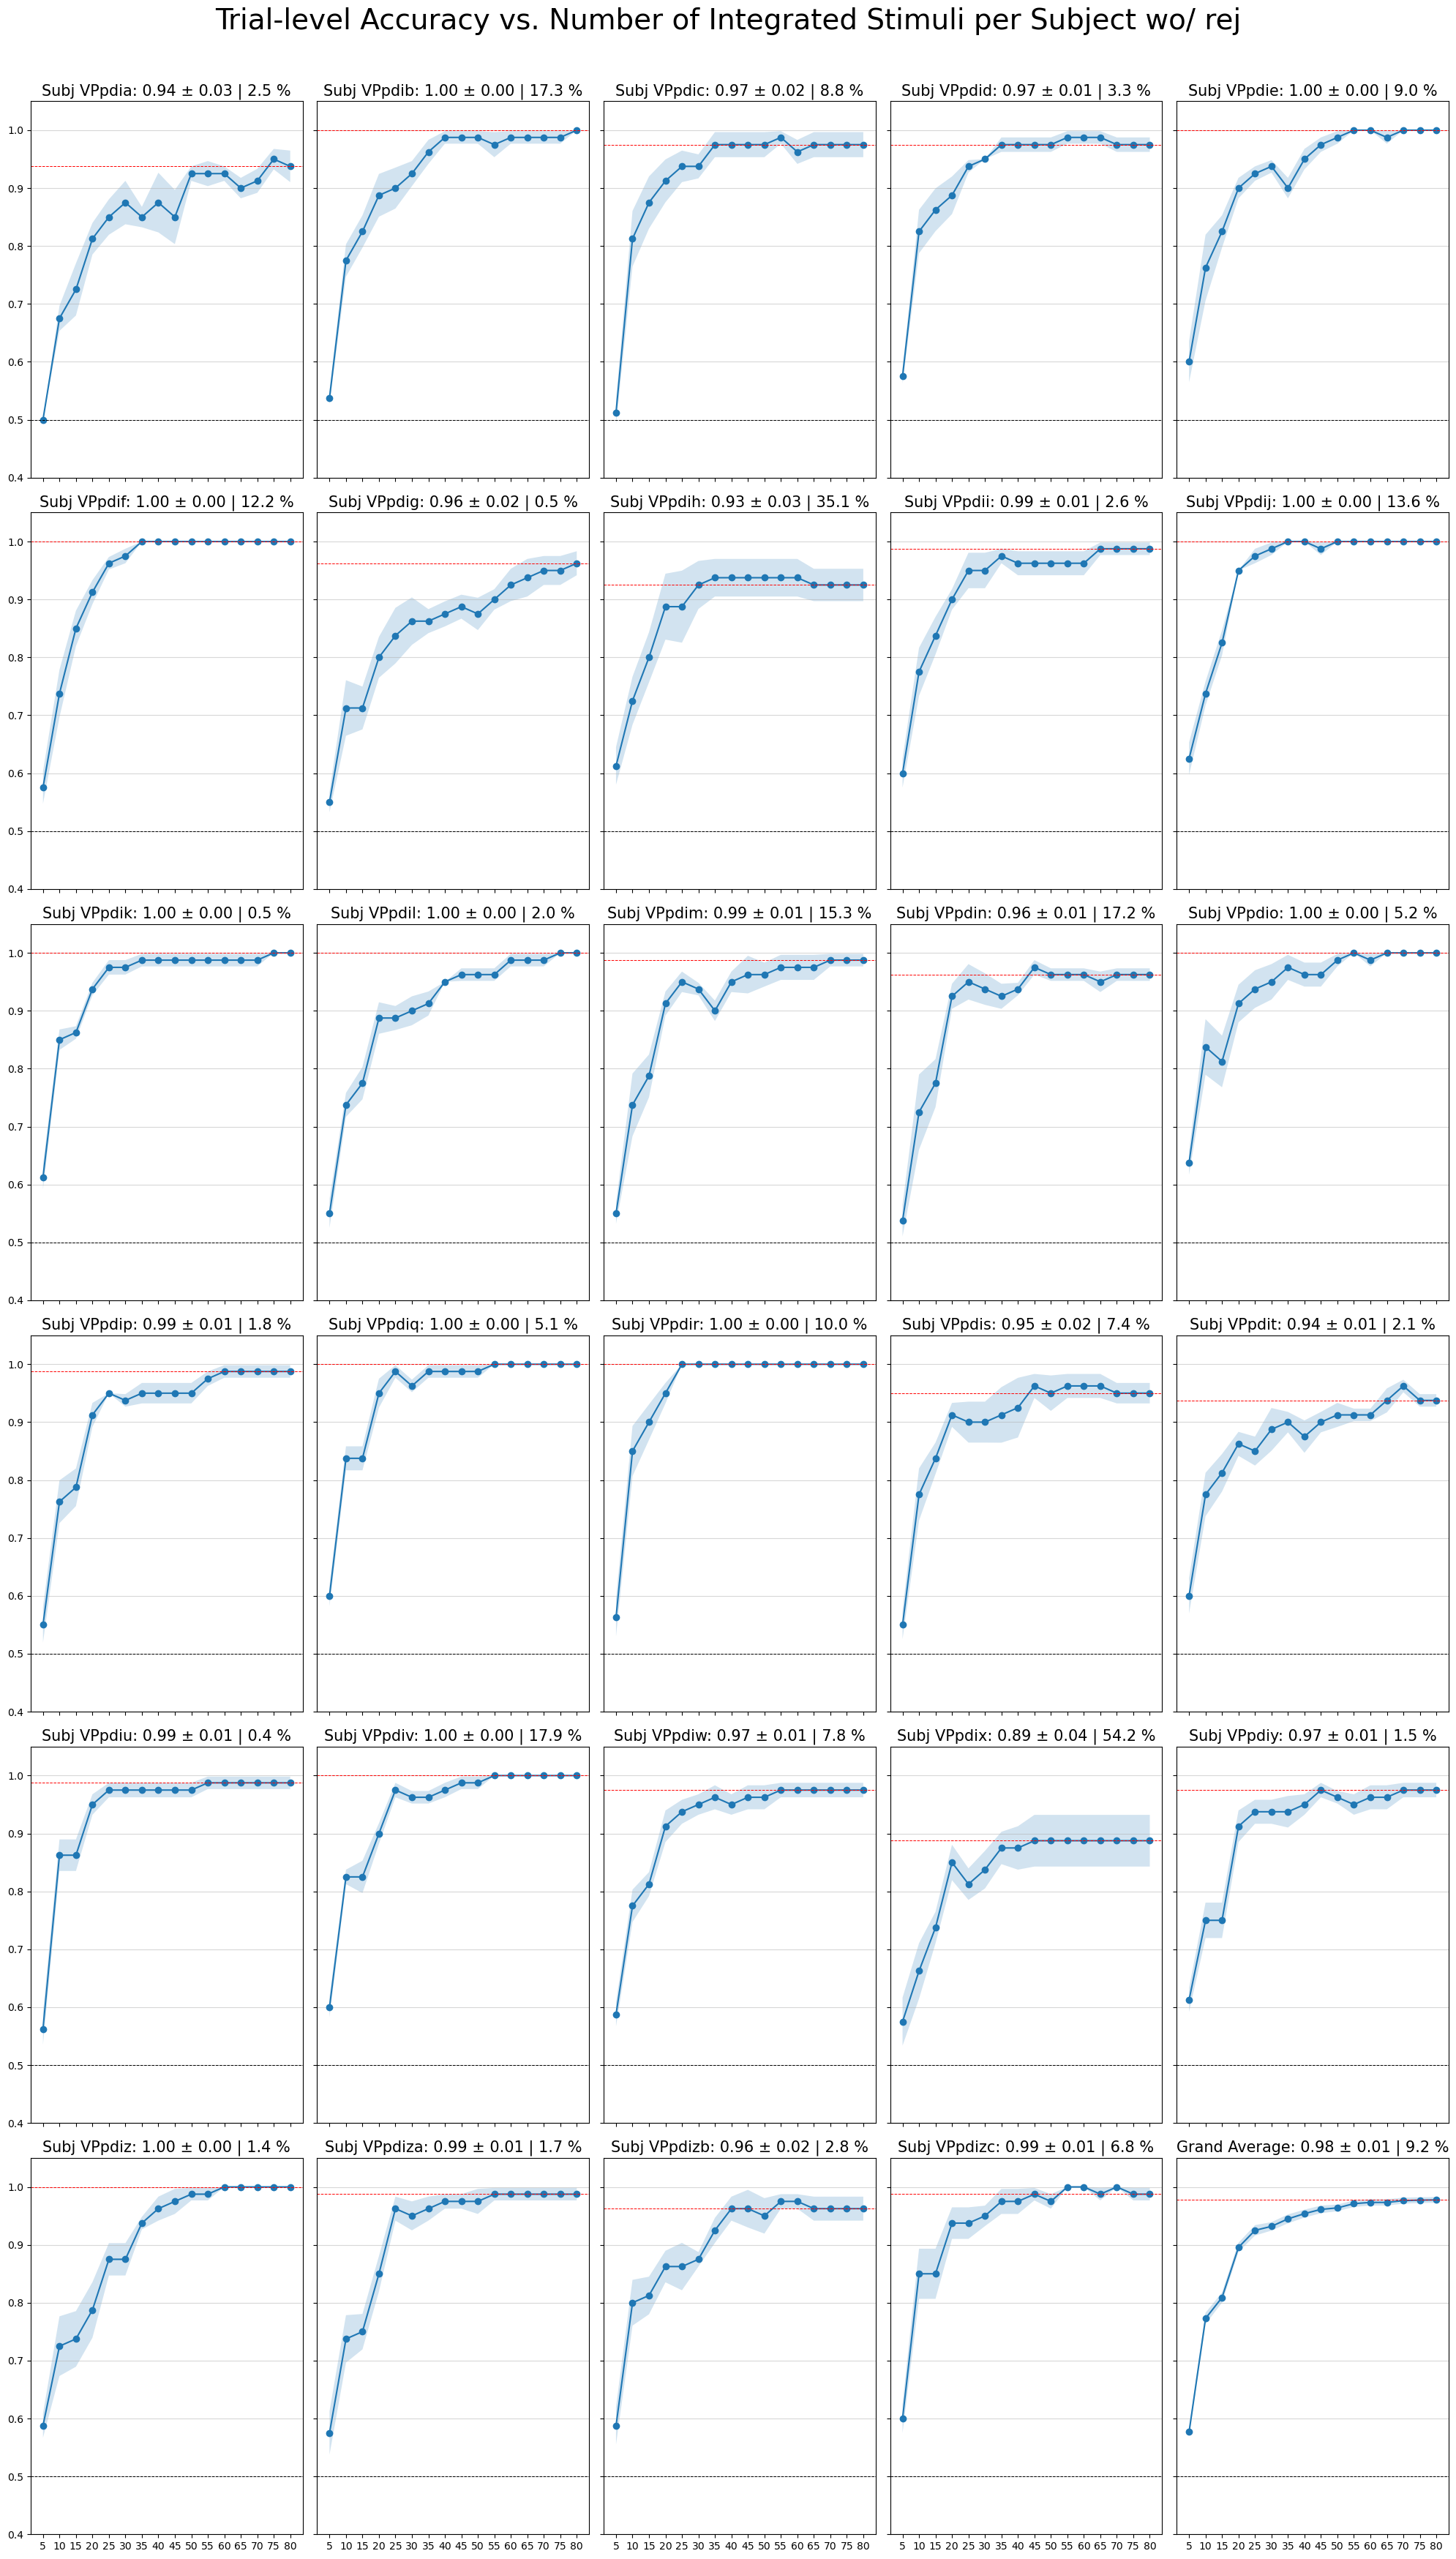

In [5]:
import matplotlib.pyplot as plt
plt.style.use('default')
# Collect subject IDs
subject_ids = list(results_decoding["subjects"].keys())

n_subjects = len(subject_ids)

# Grab the epoch bins from the keys of 'mean_accuracies' (sorted for a nice left-to-right plot)
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())

# Arrange subplots (up to 5 columns, adapt rows accordingly)
n_cols = min(5, n_subjects)
n_rows = (n_subjects + 1 + n_cols - 1) // n_cols  # +1 for the "Grand Average" subplot
fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols,
    figsize=(4 * n_cols, 6 * n_rows),
    sharey=True
)
axes = np.ravel(axes)  # Flatten so we can index them in a 1D fashion

# Plot each subject
for i, subject in enumerate(subject_ids):
    ax = axes[i]
    subject_data = results_decoding["subjects"][subject]
    # subject_data is a dict like:
    #   {fold_idx: {epoch_count -> accuracy_float}, ...}

    # collect fold-level accuracies to compute subject-level mean & SE
    subject_mean_accuracies = []
    subject_se_accuracies = []

    # Loop over each epoch_count in ascending order
    for epoch_count in epoch_bins:
        fold_accuracies = []
        for fold_idx, fold_dict in subject_data.items():
            # fold_dict is a dict {epoch_count -> accuracy_float}
            fold_accuracies.append(fold_dict[epoch_count])

        fold_accuracies = np.array(fold_accuracies)
        mean_acc = np.mean(fold_accuracies)
        se_acc = np.std(fold_accuracies) / np.sqrt(len(fold_accuracies))

        subject_mean_accuracies.append(mean_acc)
        subject_se_accuracies.append(se_acc)

    # Convert lists to arrays
    subject_mean_accuracies = np.array(subject_mean_accuracies)
    subject_se_accuracies = np.array(subject_se_accuracies)

    # Compute upper/lower bounds for shading
    lower_bound = subject_mean_accuracies - subject_se_accuracies
    upper_bound = subject_mean_accuracies + subject_se_accuracies

    # Plot
    ax.plot(epoch_bins, subject_mean_accuracies, '-o', label=f"Subject {subject}")
    ax.fill_between(epoch_bins, lower_bound, upper_bound, alpha=0.2)

    # Show final-epoch summary in the title
    ax.set_title(
        f"Subj {subject}: {subject_mean_accuracies[-1]:.2f} ± {subject_se_accuracies[-1]:.2f} | {(discarded_epochs_info[subject] / 6400 * 100):.1f} %",
        fontsize=15
    )
    ax.grid(alpha=0.5, axis='y')
    # Horizontal reference lines
    ax.axhline(y=subject_mean_accuracies[-1], color='red', linestyle='--', linewidth=0.7)
    ax.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)  # chance line
    
    ax.set_ylim(0.4, 1.0)

    # Show y-ticks only in the first column
    if i % n_cols == 0:
        ax.set_yticks(np.round(np.arange(0.4, 1.1, 0.1),1 ))
    else:
        ax.set_yticklabels(np.round(np.arange(0.4, 1.1, 0.1),1 ))

    # X-ticks only for the last row of subplots
    if i >= (n_rows - 1) * n_cols: 
        ax.set_xticks(epoch_bins)
    else:
        ax.set_xticks(epoch_bins)
        ax.set_xticklabels([])

# plot "Grand Average"

ax_grand = axes[n_subjects]

grand_mean_accuracies = np.array([
    results_decoding["mean_accuracies"][ec] for ec in epoch_bins
])
grand_se_accuracies = np.array([
    results_decoding["se_accuracies"][ec] for ec in epoch_bins
])

grand_lower_bound = grand_mean_accuracies - grand_se_accuracies
grand_upper_bound = grand_mean_accuracies + grand_se_accuracies

ax_grand.plot(epoch_bins, grand_mean_accuracies, '-o', label="Grand Average")
ax_grand.fill_between(epoch_bins, grand_lower_bound, grand_upper_bound, alpha=0.2)

ax_grand.set_title(
    f"Grand Average: {grand_mean_accuracies[-1]:.2f} ± {grand_se_accuracies[-1]:.2f} | {(np.mean(list(discarded_epochs_info.values())) / 6400 * 100):.1f} %",
    fontsize=15
)
ax_grand.grid(alpha=0.5, axis='y')
ax_grand.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)
ax_grand.axhline(y=grand_mean_accuracies[-1], color='red', linestyle='--', linewidth=0.7)
ax_grand.set_ylim(0.4, 1.05)
ax_grand.set_yticks(np.round(np.arange(0.4, 1.05, 0.1),1 ))
ax_grand.set_xticks(epoch_bins)


fig.suptitle("Trial-level Accuracy vs. Number of Integrated Stimuli per Subject wo/ rej", 
             y=0.97, fontsize=28)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save
task = "covert"
save_dir = os.path.join(plots_dir, 'decoding')
os.makedirs(save_dir, exist_ok=True)

save_path_png = join(save_dir, f"{task}_lda_p300_decC_results_perSubj_wo_baselinecorrect.png")
save_path_svg = join(save_dir, f"{task}_lda_p300_decC_results_perSubj_wo_baselinecorrect.svg")
#p#lt.savefig(save_path_png, dpi=300)
#plt.savefig(save_path_svg, dpi=300)

print(f"Plot saved to:\n  {save_path_png}")
plt.show()


## Plot only Grand Average

Accuracy at full epoch integration: 0.98 ± 0.01


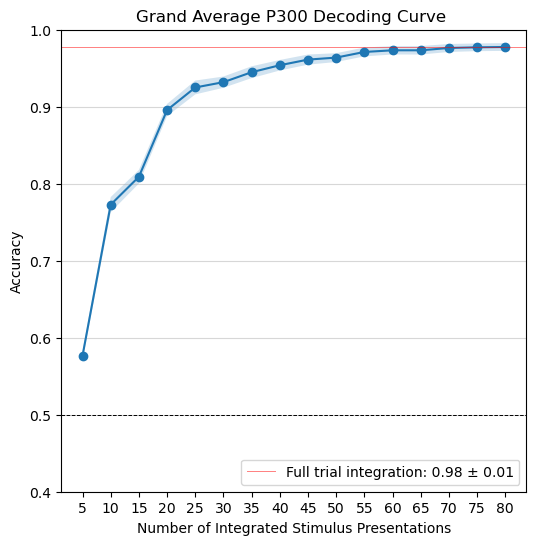

In [6]:
import matplotlib.pyplot as plt
plt.style.use('default')

# Extract epoch bins (sorted)
epoch_bins = sorted(results_decoding["mean_accuracies"].keys())

# Build arrays for plotting
mean_acc_array = np.array([results_decoding["mean_accuracies"][eb] for eb in epoch_bins])
se_acc_array   = np.array([results_decoding["se_accuracies"][eb]   for eb in epoch_bins])

# Create a single figure and axis
plt.figure(figsize=(6, 6))

# Plot the mean accuracy
plt.plot(epoch_bins, mean_acc_array, '-o', label='', color = 'tab:blue')

# Fill between mean ± SE
lower_bound = mean_acc_array - se_acc_array
upper_bound = mean_acc_array + se_acc_array
plt.fill_between(epoch_bins, lower_bound, upper_bound, alpha=0.2)

# horizontal reference lines
plt.axhline(y=0.5, color='k', linestyle='--', linewidth=0.7)  # chance line
plt.axhline(y=1.0, color='k', linestyle='--', linewidth=0.7)  # perfect accuracy
plt.axhline(y=mean_acc_array[-1], color='red', linestyle='-', linewidth=0.7, alpha = 0.5, label = f'Full trial integration: {mean_acc_array[-1]:.2f} ± {se_acc_array[-1]:.2f}')
# Axis labels, title, and limits
plt.xlabel("Number of Integrated Stimulus Presentations", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.ylim(0.4, 1.0)
plt.xticks(epoch_bins)
plt.title("Grand Average P300 Decoding Curve ", fontsize=12)
plt.grid(alpha=0.5, axis='y')
plt.legend(loc='lower right')

# Save the figure

task = "covert"
save_dir = os.path.join(plots_dir, 'decoding')
os.makedirs(save_dir, exist_ok=True)


#plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_GA_wo_rej.png"), dpi=300)
#plt.savefig(join(save_dir, f"{task}_lda_p300_decC_results_GA_wo_rej.svg"), dpi=300)
plt.plot()
print (f"Accuracy at full epoch integration: {mean_acc_array[-1]:.2f} ± {se_acc_array[-1]:.2f}")
